## Comparing random sampling of text corpus to original after LDA

In [9]:
import numpy as np
import random
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# import sklearn dataset
newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
documents = newsgroups.data
original_labels = newsgroups.target

# convert to bag of words
vectorizer = CountVectorizer(stop_words='english')
word_counts = vectorizer.fit_transform(documents)
vocab = np.array(vectorizer.get_feature_names_out())

In [5]:
def resample_documents(word_counts, depth=100, return_labels=False):
    new_docs = []
    new_labels = []

    for doc_idx in range(word_counts.shape[0]):
        word_indices = word_counts[doc_idx].nonzero()[1]  # nonzero words in the doc

        if len(word_indices) == 0:  # skip empty documents
            new_docs.append("")
            if return_labels:
                new_labels.append(original_labels[doc_idx])
            continue

        word_frequencies = word_counts[doc_idx].toarray().flatten()[word_indices]
        probabilities = word_frequencies / word_frequencies.sum()

        sampled_indices = np.random.choice(word_indices, size=depth, p=probabilities)
        new_doc = ' '.join(vocab[sampled_indices])

        new_docs.append(new_doc)
        if return_labels:
            new_labels.append(original_labels[doc_idx])

    if return_labels:
        return new_docs, new_labels
    return new_docs

In [7]:
# run LDA on the original dataset
num_topics = 10
lda_original = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_original.fit(word_counts)
original_topic_distributions = lda_original.components_ / lda_original.components_.sum(axis=1, keepdims=True)

# display the top words for each topic
vocab = np.array(vectorizer.get_feature_names_out())

for topic_idx, topic in enumerate(lda_original.components_):
    top_words = vocab[np.argsort(topic)[-10:]]  # Top 10 words
    print(f"Topic {topic_idx}: {' '.join(top_words)}")

Topic 0: hockey com play season new games year team game edu
Topic 1: 1t 34u 1d9 145 pl a86 b8f g9v max ax
Topic 2: pts bh 15 mov 20 50 10 file 00 db
Topic 3: said think know stephanopoulos use people don president mr gun
Topic 4: com using application 55 edu server use widget motif window
Topic 5: know just don say believe think does jesus people god
Topic 6: dos just does know card thanks like drive use windows
Topic 7: information entry output pub available ftp program space edu file
Topic 8: armenians armenian time car know don said people like just
Topic 9: make know key use just like think government don people



 Running LDA at sampling depth 50...

 Top words per topic (Depth=50):
Topic 0: time does don like year games just team think game
Topic 1: good work use deletion just file like does people ax
Topic 2: believe got case like list don sorry use just good
Topic 3: faq hope right probably think just agree people com test
Topic 4: ll using problem edu like window thanks don just know
Topic 5: jesus time life think like believe true say people god
Topic 6: ve used need problem hi thanks card use drive windows
Topic 7: let like ftp sure don edu mail does thanks know
Topic 8: mean space wanted think car don like bike just know
Topic 9: did time think does make use government don key like


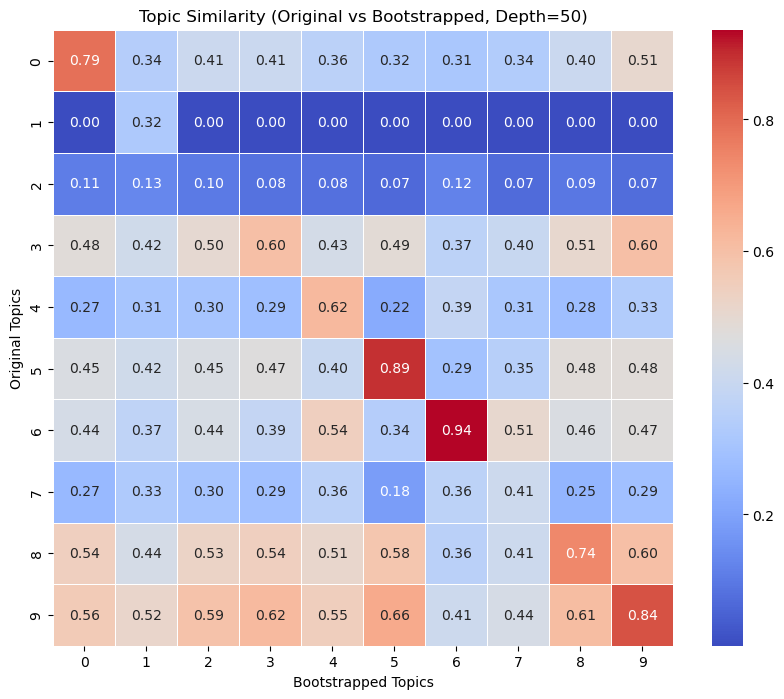

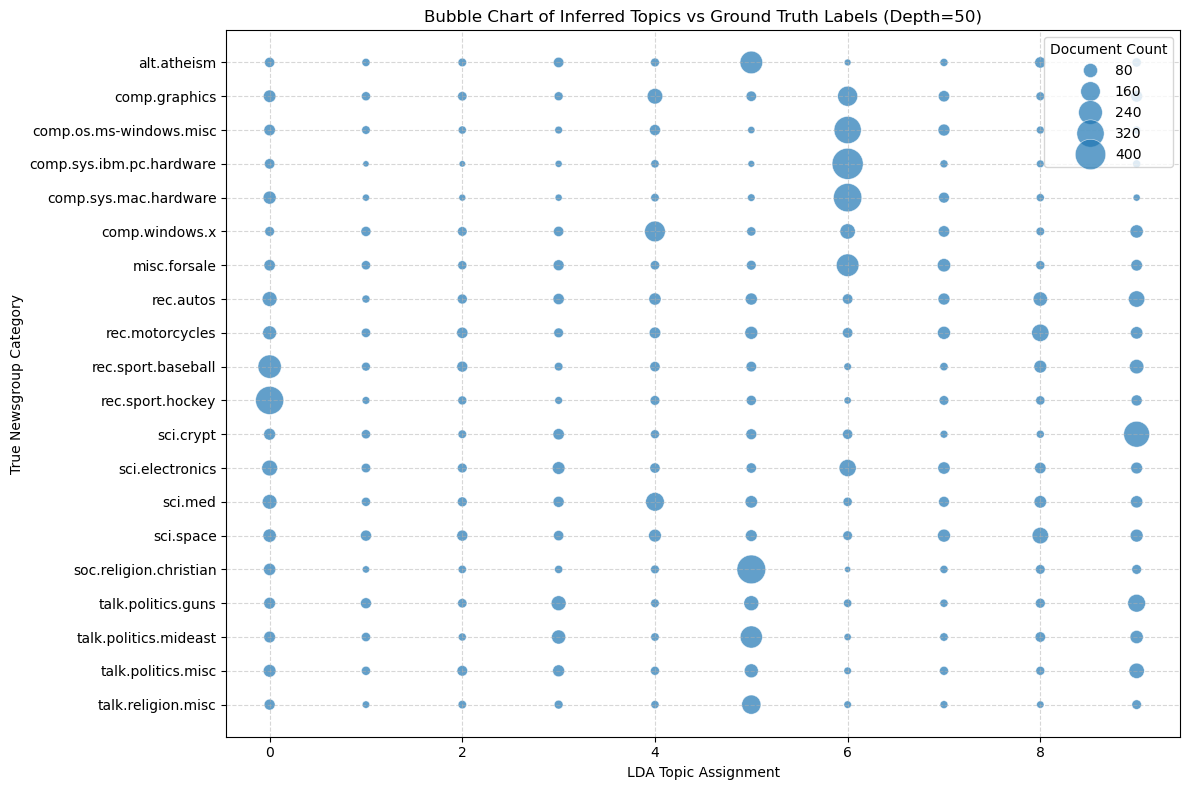


 Running LDA at sampling depth 100...

 Top words per topic (Depth=100):
Topic 0: know time like edu games team year just think game
Topic 1: deletion talking program try does work version use ax file
Topic 2: sorry send got case don use ve list just good
Topic 3: point ll people agree steve just think oh com test
Topic 4: use server problem edu like don window thanks know just
Topic 5: like just life said believe don think say god people
Topic 6: does pc software hi thanks need use card drive windows
Topic 7: info edu mail sure don new like does know thanks
Topic 8: time long think good bike don know like just car
Topic 9: time good does think government make don use like key


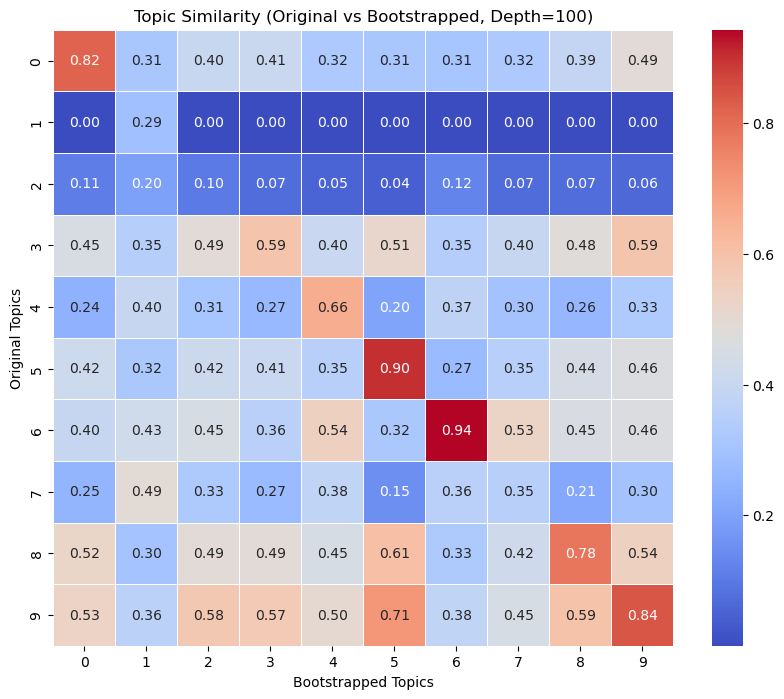

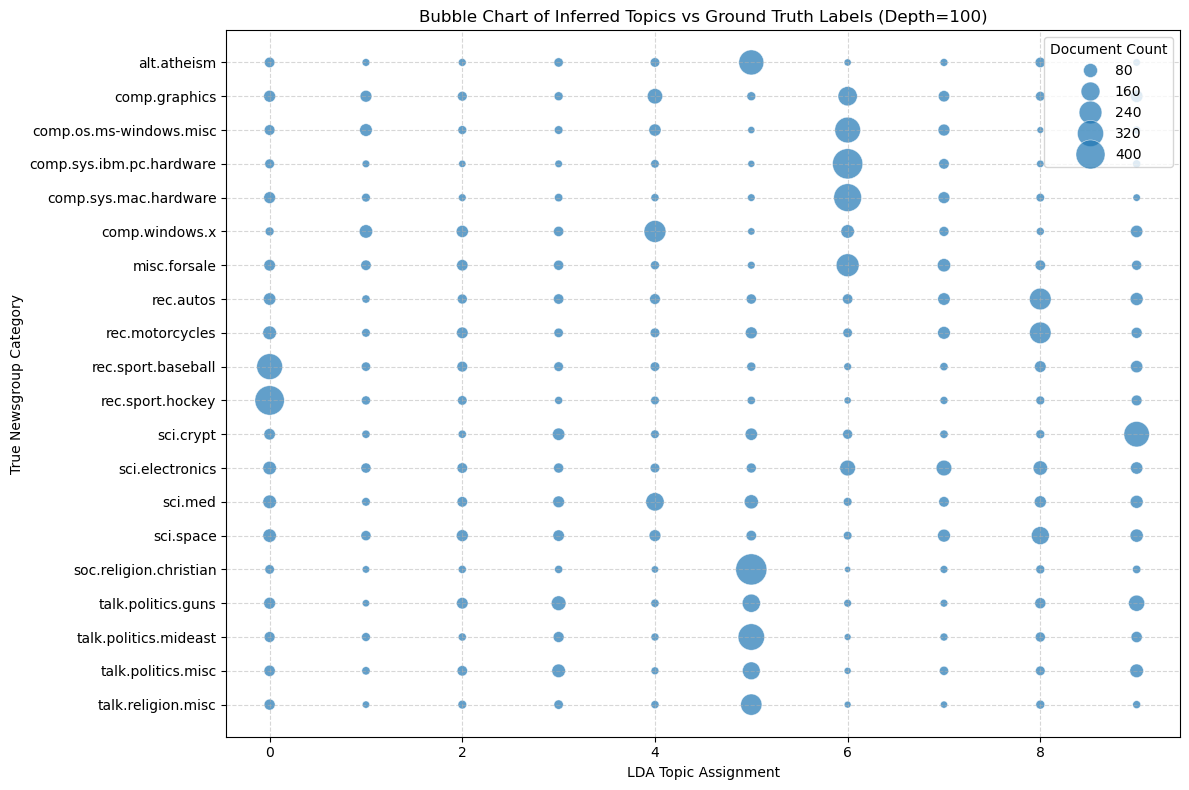


 Running LDA at sampling depth 200...

 Top words per topic (Depth=200):
Topic 0: ll like don play just games year team think game
Topic 1: problem value try deletion version 11 work use ax file
Topic 2: believe mr case sorry ve use good don just list
Topic 3: ll probably oh just gun think people agree com test
Topic 4: windows files help program don window like know just thanks
Topic 5: jesus true like life believe don think say people god
Topic 6: does problem software pc dos need use card windows drive
Topic 7: looking email like new price edu mail does know thanks
Topic 8: new time space think know bike don like just car
Topic 9: does time think make people use like government don key


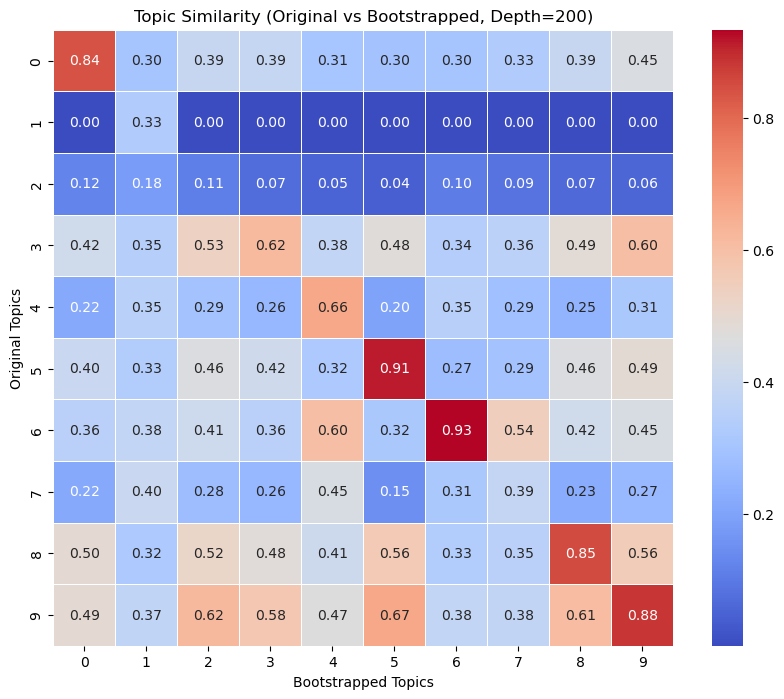

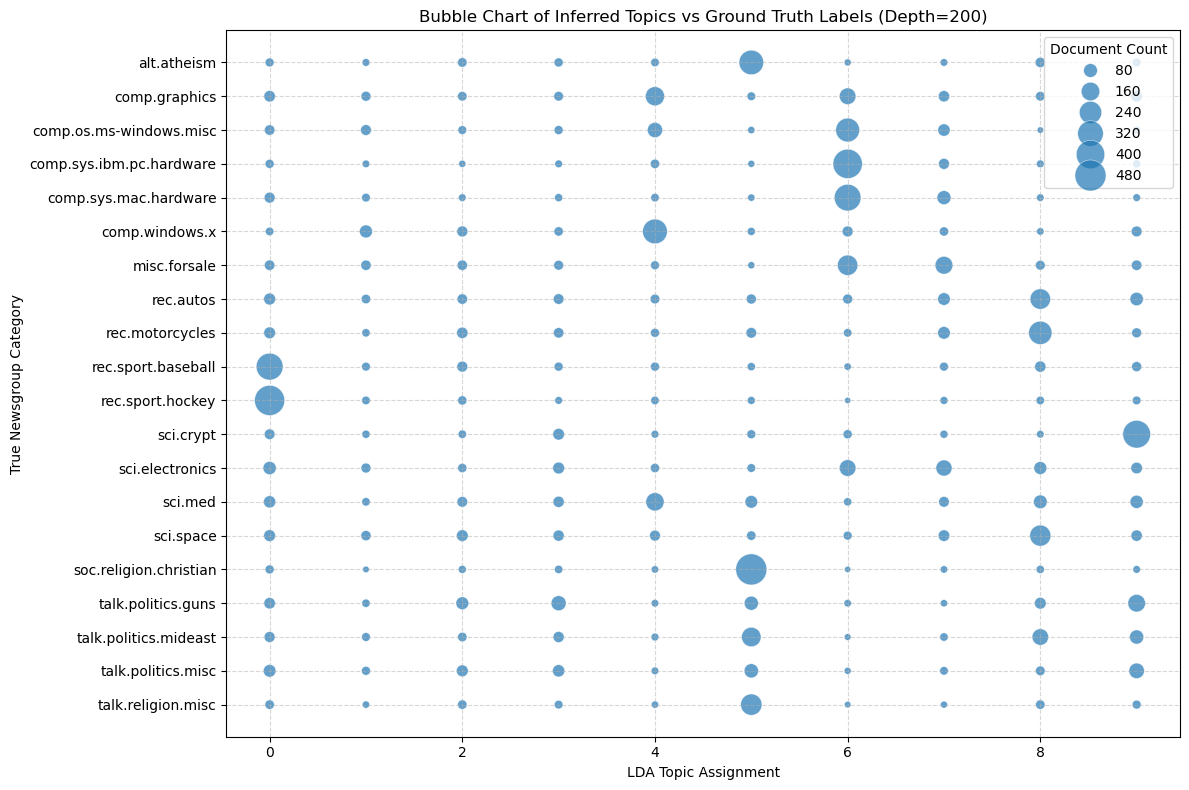


 Running LDA at sampling depth 500...

 Top words per topic (Depth=500):
Topic 0: like don edu play just games year think team game
Topic 1: read try work deletion chris does use 11 file ax
Topic 2: word like case sorry don use ve just good list
Topic 3: ll probably agree oh just think gun people com test
Topic 4: does hi files program don window like just know thanks
Topic 5: does just know life believe think don say god people
Topic 6: just software video pc dos need use card windows drive
Topic 7: don price new like email edu mail does know thanks
Topic 8: new time bike space think know don like just car
Topic 9: good think people time make like use don government key


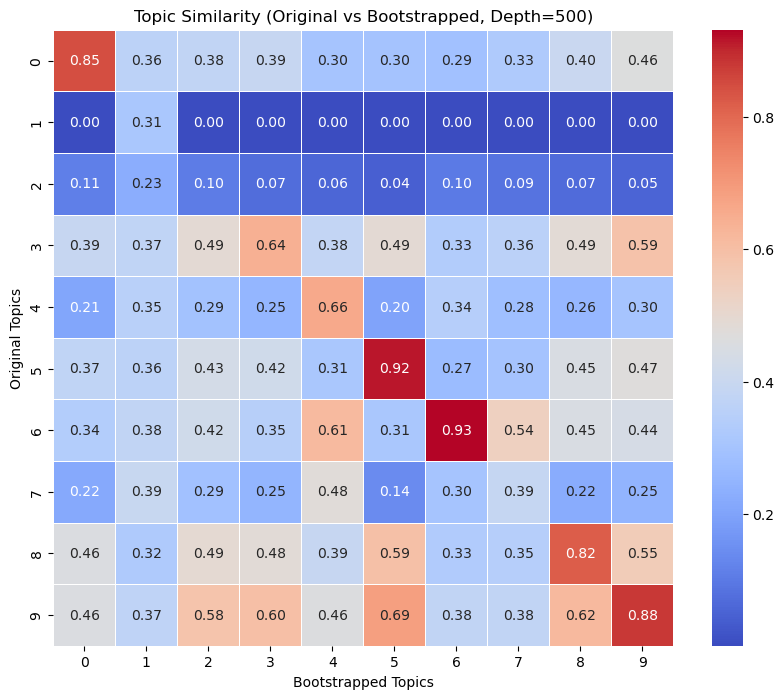

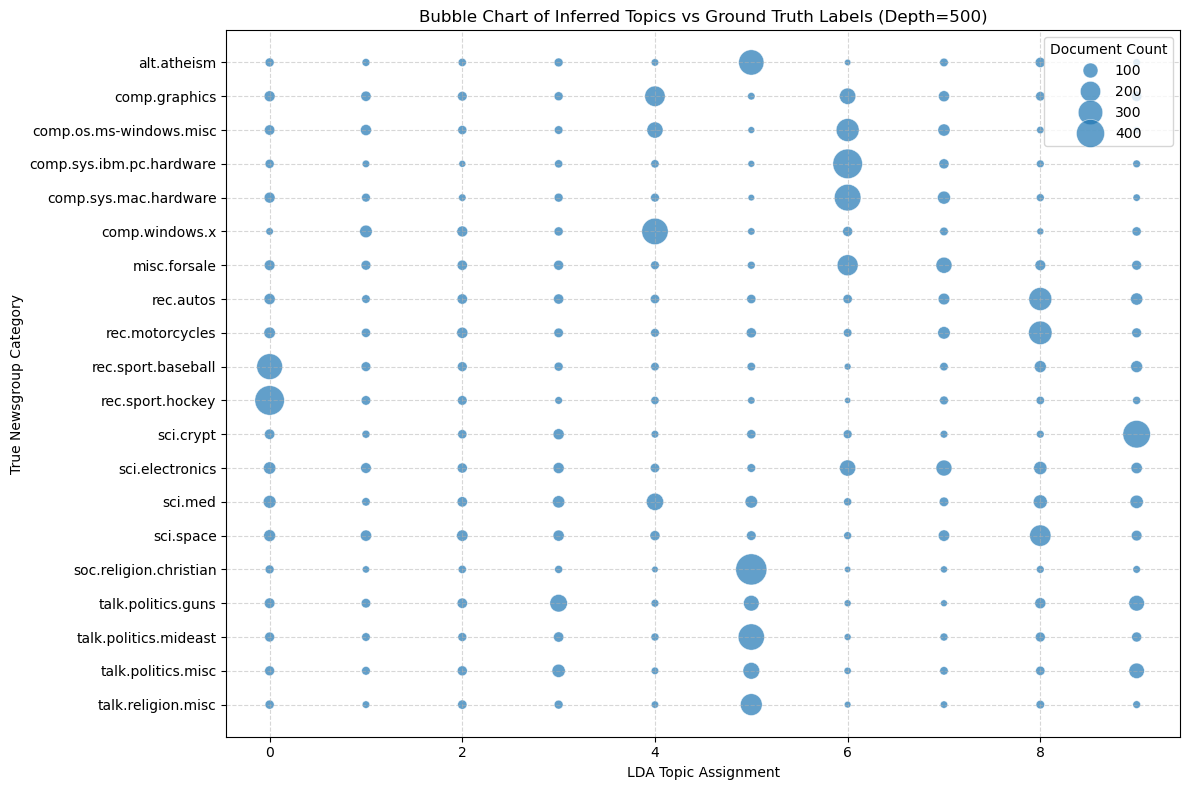

In [11]:
# run LDA on each depth
sampling_depths = [50, 100, 200, 500]
num_topics = 10

for depth in sampling_depths:
    print(f"\n Running LDA at sampling depth {depth}...")

    # resample and revectorize
    resampled_docs, resampled_labels = resample_documents(word_counts, depth=depth, return_labels=True)
    resampled_counts = vectorizer.transform(resampled_docs)

    # run LDA on bootstrapped data
    lda_bootstrap = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_bootstrap.fit(resampled_counts)
    bootstrap_topic_distributions = lda_bootstrap.components_ / lda_bootstrap.components_.sum(axis=1, keepdims=True)

    # top words per topic
    print(f"\n Top words per topic (Depth={depth}):")
    for topic_idx, topic in enumerate(lda_bootstrap.components_):
        top_words = [vocab[i] for i in topic.argsort()[-10:]]  # Get top 10 words
        print(f"Topic {topic_idx}: {' '.join(top_words)}")

    # compute cosine similarity between topics
    similarity_matrix = cosine_similarity(original_topic_distributions, bootstrap_topic_distributions)

    # plot heat map chart
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        similarity_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5
    )

    plt.title(f"Topic Similarity (Original vs Bootstrapped, Depth={depth})")
    plt.xlabel("Bootstrapped Topics")
    plt.ylabel("Original Topics")
    plt.show()

    doc_topic_probs = lda_bootstrap.transform(resampled_counts)
    topic_assignments = doc_topic_probs.argmax(axis=1)

    df = pd.DataFrame({
        'TrueLabel': resampled_labels,
        'Topic': topic_assignments
    })

    # group by label-topic pair and count
    grouped = df.groupby(['TrueLabel', 'Topic']).size().reset_index(name='Count')

    # map numeric labels to category names
    grouped['TrueLabelName'] = grouped['TrueLabel'].map(lambda i: newsgroups.target_names[i])

    # plot bubble chart
    plt.figure(figsize=(12, 8))
    bubble_plot = sns.scatterplot(
        data=grouped,
        x='Topic',
        y='TrueLabelName',
        size='Count',
        legend='brief',
        sizes=(20, 500),
        alpha=0.7
    )

    plt.title(f"Bubble Chart of Inferred Topics vs Ground Truth Labels (Depth={depth})")
    plt.xlabel("LDA Topic Assignment")
    plt.ylabel("True Newsgroup Category")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.legend(loc='upper right', title='Document Count')
    plt.show()

Try training on JUST the training set vs ground truth - see how boostrapping affects actual classification
Similar to body sites, compare how no bootstrapping maps to ground truth vs each sampling depth